In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# Install dependencies
!pip install -q CompoTree
!pip install -q cilin
!pip install -q opencc

# Download font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -qo NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

# Download data
!wget -q https://github.com/liao961120/cilin/archive/refs/heads/main.zip
!unzip -q main.zip
!mv cilin-main/etc/* .

     |████████████████████████████████| 1.3 MB 9.1 MB/s 
     |████████████████████████████████| 600 kB 8.6 MB/s 
     |████████████████████████████████| 766 kB 8.0 MB/s 
--2021-12-09 01:46:47--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M   223MB/s    in 0.5s    

2021-12-09 01:46:48 (223 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

replace cilin-main/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: mv: cannot stat 'cilin-main/etc/*': No such file or directory


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager  

# Set chinese font for plotting
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    try:
        font_manager.fontManager.addfont(font_file)
    except: pass
plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [14]:
import json
import numpy as np
import pandas as pd
from cilin import Cilin
from CompoTree import Radicals
from collections import Counter
from itertools import product, chain
from random import sample
from utils import *

C = Cilin(trad=True)
def all_words():
    return chain.from_iterable(C.category_split().values())
# Tagger = RadicalSemanticTagger(all_words=all_words, bigram=False)  # Use unigram feature only

## 同義詞詞林

<img src="https://github.com/liao961120/cilin/raw/main/etc/cilin_encoding.png" width=59% style="display:inlin-block">

<img src="https://github.com/liao961120/cilin/raw/main/etc/cilin_hierarchy.png" width=40% style="display:inlin-block">


In [105]:
for t in "D Da Da15 Da15A Da15B".split():
    print(t, "\t Class label   :  ", C.get_tag(t))
    print("\t Num. of members: ", len(C.get_members(t)))
    print("\t Example members: ", list(C.get_members(t))[:10])
    print("\t Semantic tags  : ", Tagger.bow(C.get_members(t)).most_common(5))
    print()

D 	 Class label   :   抽象事物
	 Num. of members:  20865
	 Example members:  ['語序', '農學會', '背日性', '醫學', '極', '短見', '楷範', '幹勁', '兩河鎮', '盲字']
	 Semantic tags  :  [('無生命', 6533), ('NULL', 4795), ('植物', 3144), ('人體四肢', 3014), ('穿著器物', 2444)]

Da 	 Class label   :   事情 情況
	 Num. of members:  1971
	 Example members:  ['困苦', '光合作用', '業績', '革命史', '過失', '望', '訟案', '憾', '藝途', '行政']
	 Semantic tags  :  [('無生命', 408), ('NULL', 267), ('生命性質', 200), ('人體四肢', 197), ('植物', 163)]

Da15 	 Class label   :   是非 差錯 漏洞
	 Num. of members:  57
	 Example members:  ['病', '謬', '漏洞', '不對', '失之偏頗', '誰是誰非', '漏子', '紕繆', '錯處', '尾巴']
	 Semantic tags  :  [('NULL', 20), ('無生命', 16), ('野獸', 7), ('生命性質', 6), ('人體四肢', 6)]

Da15A 	 Class label   :   是非 好壞 長短 黑白 曲直 是非曲直 是是非非 對錯 貶褒 敵友 有得有失 大是大非
	 Num. of members:  13
	 Example members:  ['黑白', '是非曲直', '是非', '大是大非', '好壞', '有得有失', '曲直', '長短', '誰是誰非', '是是非非']
	 Semantic tags  :  [('NULL', 9), ('無生命', 7), ('生命性質', 3), ('顏色_顏色', 1), ('人體頭部', 1)]

Da15B 	 Class label   :   差錯 過錯 錯誤 錯處 

## One-Character Words

### EDA

In [56]:
Tagger = RadicalSemanticTagger(all_words=all_words(), bigram=True, word_type="single")
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)
rows = [C.get_tag(x) for x in DTM.documents]
columns = DTM.features
print(DTM.count_mat.shape)
DTM.count_mat

(12, 23)


array([[ 30,  36,  52,   0,  15,   2,   3,  17,   9,   0,   5,   4,   2,
          8,  18,   4,  25,  19,   7,   1,   7,   0,   1],
       [ 92,  17,  12,   9, 117,   4,   3,  69,  79,  12,  33,  49,  15,
         33, 379,  27, 406,  35,  52,   5, 101, 156,  10],
       [ 21,   8,   3,   1,  17,   0,   1,  13,  23,   1,  19,   0,   2,
          7,  21,   3,  64,  13,   1,   1,   7,   2,   1],
       [167,  69,  21,   1,  91,   4,  29,  58,  47,   1,  66,  22,   9,
         31, 123,  34, 191,  50,  24,  12,  56,  34,  13],
       [ 84,  57,  23,   2,  71,   3,  38,  43,  38,   3,  26,  21,   5,
         15,  64,  27, 207,  55,  19,  15,  40,  25,  17],
       [ 31,  16,   1,   0, 224,   3,   3, 101,  18,   2,   4,   9,   3,
         12,  28,  35,  88,  67,  11,   7,  24,   6,   3],
       [ 37,  15,   6,   0,  28,   0,  68,  19,   7,   3,   6,   5,   1,
          3,   9,   2,  96,  15,   5,   4,   3,   3,   1],
       [148,  60,  20,   1, 204,   8,  20,  67,  31,   2,  23,  20,   7,
   

In [59]:
def heatmap(mat):
    dfT = pd.DataFrame(mat, index=rows, columns=columns)
    ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                     cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                    bottom=False, top = False, labeltop=True)
    plt.xticks(rotation=90, fontsize=8)
    plt.show()

#### $P(Lexical Group|Radical Type)$

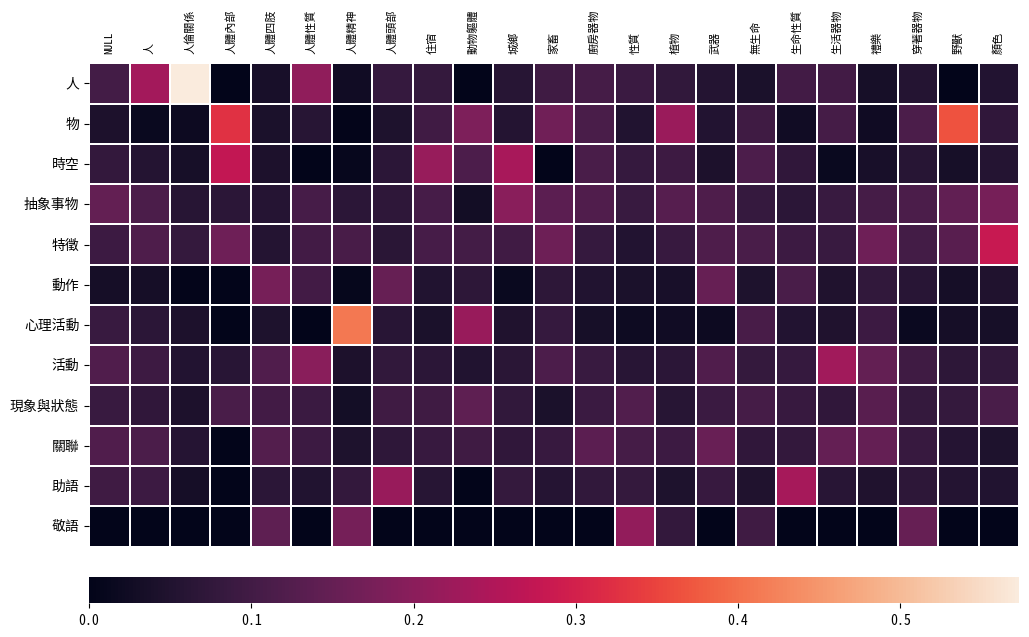

In [61]:
# np.sum(DTM.np, axis=0).shape
plt.figure(figsize=(12, 8), dpi=100)
P_givenFeat = DTM.np / np.sum(DTM.np, axis=0)
heatmap(P_givenFeat)

#### $P(Radical Type|Lexical Group)$

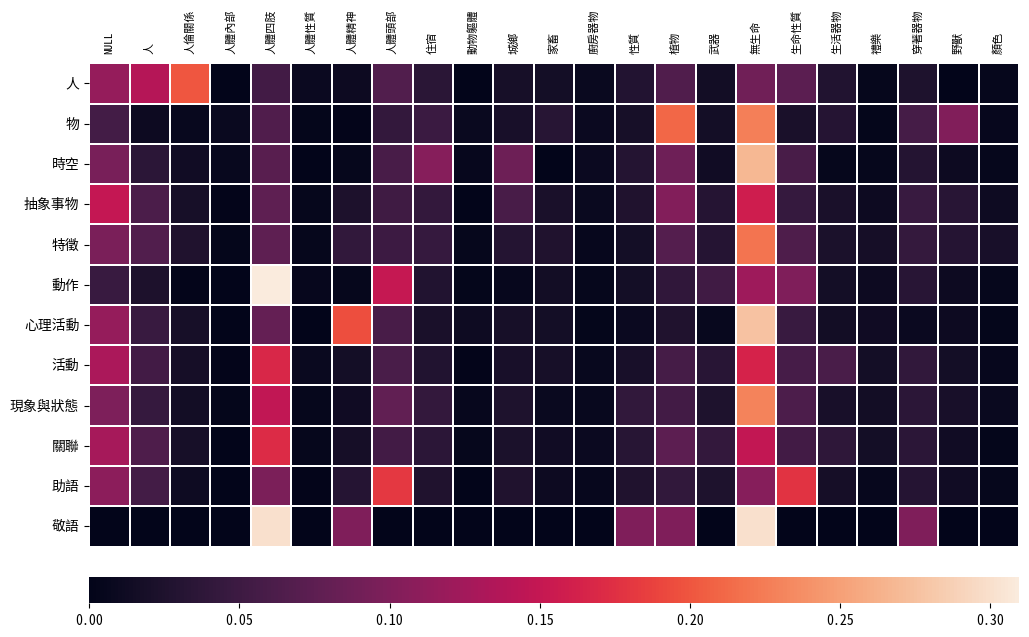

In [72]:
plt.figure(figsize=(12, 8), dpi=100)
P_givenDoc = (DTM.np.T / np.sum(DTM.np, axis=1)).T
heatmap(P_givenDoc)

#### Tf-IDF Matrix (single-character words)

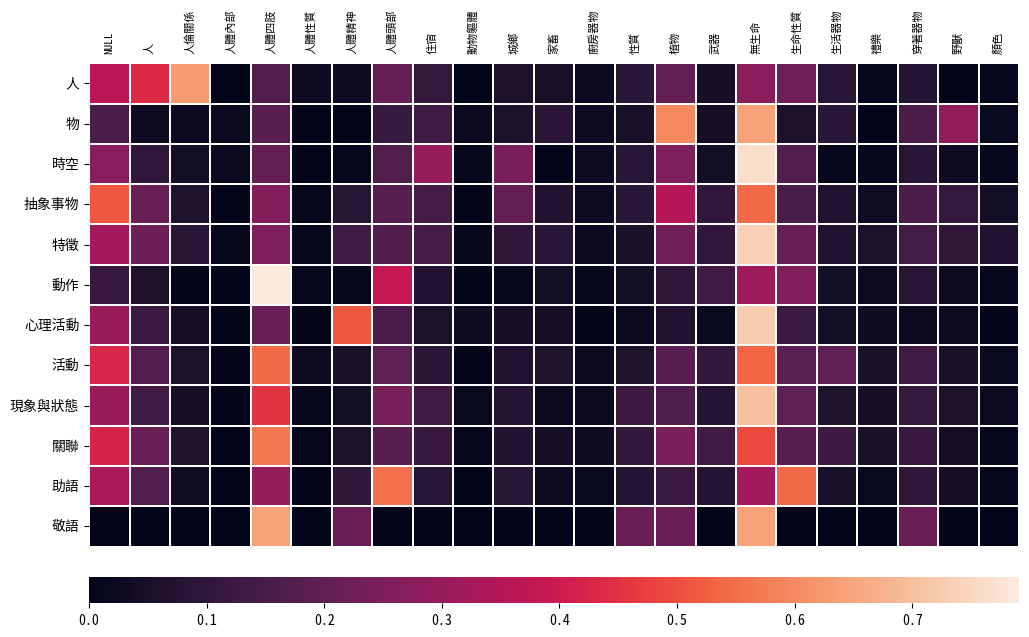

In [42]:
plt.figure(figsize=(12, 8), dpi=100)

dfT = pd.DataFrame(DTM.np, index=[C.get_tag(x) for x in DTM.documents], columns=DTM.features)
ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                 cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
# ax.set_yticks(range(dfT.shape[0])) # <--- set the ticks first
# ax.set_yticklabels(dfT.index, fontsize=10)
# ax.set_xticks(range(dfT.shape[1])) # <--- set the ticks first
# ax.set_xticklabels(dfT.columns)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                bottom=False, top = False, labeltop=True)
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [88]:
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)
df_feat, df_tgt = DTM.pd, DTM.df_tgt

In [89]:
pd.DataFrame(DTM.np, index=DTM.documents, columns=DTM.features)

,NULL,人,人倫關係,人體內部,人體四肢,人體性質,人體精神,人體頭部,住宿,動物軀體,...,性質,植物,武器,無生命,生命性質,生活器物,禮樂,穿著器物,野獸,顏色
Aa01,0.406219,0.308751,0.406144,0.0,0.081704,0.0,0.000000,0.204047,0.449845,0.0,...,0.124908,0.268748,0.000000,0.070207,0.410127,0.251147,0.0,0.000000,0.0,0.0
Aa02,0.228373,0.433944,0.570828,0.0,0.000000,0.0,0.185307,0.430175,0.000000,0.0,...,0.175555,0.000000,0.177763,0.197350,0.288213,0.000000,0.0,0.000000,0.0,0.0
Aa03,0.434502,0.183471,0.000000,0.0,0.000000,0.0,0.470086,0.181878,0.000000,0.0,...,0.000000,0.159700,0.000000,0.625794,0.182784,0.000000,0.0,0.000000,0.0,0.0
Aa04,0.535627,0.678515,0.446274,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.231432,0.000000,0.000000,0.0,0.000000,0.0,0.0
Aa05,0.843837,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.310149,0.437889,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
La02,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
La03,0.000000,0.000000,0.000000,0.0,0.469357,0.0,0.000000,0.000000,0.000000,0.0,...,0.717546,0.514618,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
La04,0.000000,0.000000,0.000000,0.0,0.778462,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.334462,0.000000,0.000000,0.0,0.531161,0.0,0.0
La05,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.882661,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.470011,0.000000,0.000000,0.0,0.000000,0.0,0.0


### (Multinomial) Naive Bayes Classifier

In [144]:
from sklearn.naive_bayes import MultinomialNB

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['C 時空', 'F 動作', 'I 現象與狀態', 'J 關聯', 'L 敬語']


,precision,recall,f1-score,support
A 人,0.484848,0.266667,0.344086,60.000000
B 物,0.430000,0.716667,0.537500,120.000000
C 時空,0.000000,0.000000,0.000000,30.000000
D 抽象事物,0.184211,0.080460,0.112000,87.000000
E 特徵,0.291667,0.077778,0.122807,90.000000
F 動作,0.000000,0.000000,0.000000,29.000000
G 心理活動,0.375000,0.136364,0.200000,22.000000
H 活動,0.300505,0.804054,0.437500,148.000000
I 現象與狀態,0.000000,0.000000,0.000000,64.000000
J 關聯,0.000000,0.000000,0.000000,22.000000


#### Permutation Importance: Selecting Important Features

In [146]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, r2_score

# df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': 'f1_weighted',
}
imps = permutation_importance(model, X_test, y_test, scoring=scoring, #'f1_micro',  #scoring, #['f1_micro', 'accuracy'],
                              n_repeats=2, n_jobs=-1, random_state=100)

In [147]:
importances = imps['f1']['importances_mean']
# std = imps['f1']['importances_std']

# model.score(X_test, y_test)
indices = np.argsort(importances)[::-1]

df_importance = []
# Print the feature ranking
# features = list(df_feat.columns)
for i in range(X_test.shape[1]):
    df_importance.append(
        ( 
          imps['accuracy']['importances_mean'][i],
          imps['f1']['importances_mean'][i],
          imps['precision']['importances_mean'][i],
          imps['recall']['importances_mean'][i],
        )
    )
df_importance = pd.DataFrame(df_importance, index=df_feat.columns, 
                             columns=['accuracy', 'f1', 'precision', 'recall'])
df_importance

,accuracy,f1,precision,recall
NULL,-0.002104,-0.002106,-0.002693,-0.002104
人,0.012623,0.012251,0.008774,0.012623
人倫關係,0.023843,0.024666,0.026733,0.023843
人體內部,0.002805,0.001484,0.000611,0.002805
人體四肢,0.031557,0.028895,0.022279,0.031557
人體性質,0.003506,0.002787,0.002049,0.003506
人體精神,0.030856,0.029688,0.039878,0.030856
人體頭部,0.009116,0.014226,-0.000815,0.009116
住宿,0.002104,0.000062,-0.046108,0.002104
動物軀體,0.005610,0.004253,0.004957,0.005610


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5]),
 [Text(0.5, 1, 'NULL'),
  Text(1.5, 1, '人'),
  Text(2.5, 1, '人倫關係'),
  Text(3.5, 1, '人體內部'),
  Text(4.5, 1, '人體四肢'),
  Text(5.5, 1, '人體性質'),
  Text(6.5, 1, '人體精神'),
  Text(7.5, 1, '人體頭部'),
  Text(8.5, 1, '住宿'),
  Text(9.5, 1, '動物軀體'),
  Text(10.5, 1, '城鄉'),
  Text(11.5, 1, '家畜'),
  Text(12.5, 1, '廚房器物'),
  Text(13.5, 1, '性質'),
  Text(14.5, 1, '植物'),
  Text(15.5, 1, '武器'),
  Text(16.5, 1, '無生命'),
  Text(17.5, 1, '生命性質'),
  Text(18.5, 1, '生活器物'),
  Text(19.5, 1, '禮樂'),
  Text(20.5, 1, '穿著器物'),
  Text(21.5, 1, '野獸'),
  Text(22.5, 1, '顏色')])

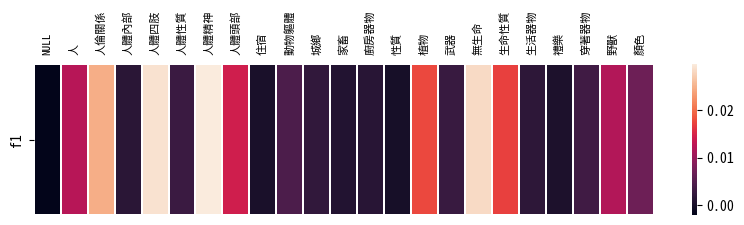

In [148]:
plt.figure(figsize=(10, 2), dpi=100)
sns.heatmap(df_importance[['f1']].T, xticklabels=True, linewidths=0.01, linecolor='white', 
                 cbar_kws=dict(orientation='vertical', aspect=35, pad=0.05))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                bottom=False, top = False, labeltop=True)
plt.xticks(rotation=90, fontsize=8)

In [149]:
df_importance_selected = df_importance.copy()

#### Feature importance of each class

In [150]:
from copy import deepcopy

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

# Base model
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# print("Not predicted:", sorted(set(y_train) - set(predictions)))
scores = classification_report(y_test, predictions, pandas=False)
baseScore = deepcopy(scores)

In [151]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score

scoreDiff = {}
rmFeat = []
for col in df_importance_selected.index:
    # X_train_drop, X_test_drop = X_train.drop(columns=[col]), X_test.drop(columns=[col])
    # Shuffle
    X_train_drop, X_test_drop = X_train.copy(deep=True), X_test.copy(deep=True)
    X_train_drop[col] = X_train_drop[col].sample(frac=1, random_state=100).values
    X_test_drop[col] = X_test_drop[col].sample(frac=1, random_state=100).values
    # df1['HS_FIRST_NAME'] = df[4].sample(frac=1).values

    rmFeat.append(col)
    model = MultinomialNB(alpha=0.001)
    model.fit(X_train_drop, y_train)
    predictions = model.predict(X_test_drop)
    # print("Not predicted:", sorted(set(y_train) - set(predictions)))
    scores = classification_report(y_test, predictions, pandas=False)

    for cls, val in scores.items():
        # scoreDiff.setdefault(cls, [])
        if cls == 'accuracy':
            if 'accuracy' not in scoreDiff:
                scoreDiff['accuracy'] = []
            scoreDiff['accuracy'].append(baseScore['accuracy']- val)
        else:
            for stat, val in val.items():
                base_val = baseScore[cls][stat]
                k = f"{cls}_{stat}"
                if any(x in k for x in 'support macro weighted'.split()): continue
                if "f1" not in k: continue  # use F1 score only
                if k not in scoreDiff:
                    scoreDiff[k] = []
                scoreDiff[k].append(base_val - val)

df = pd.DataFrame(scoreDiff, index=rmFeat)

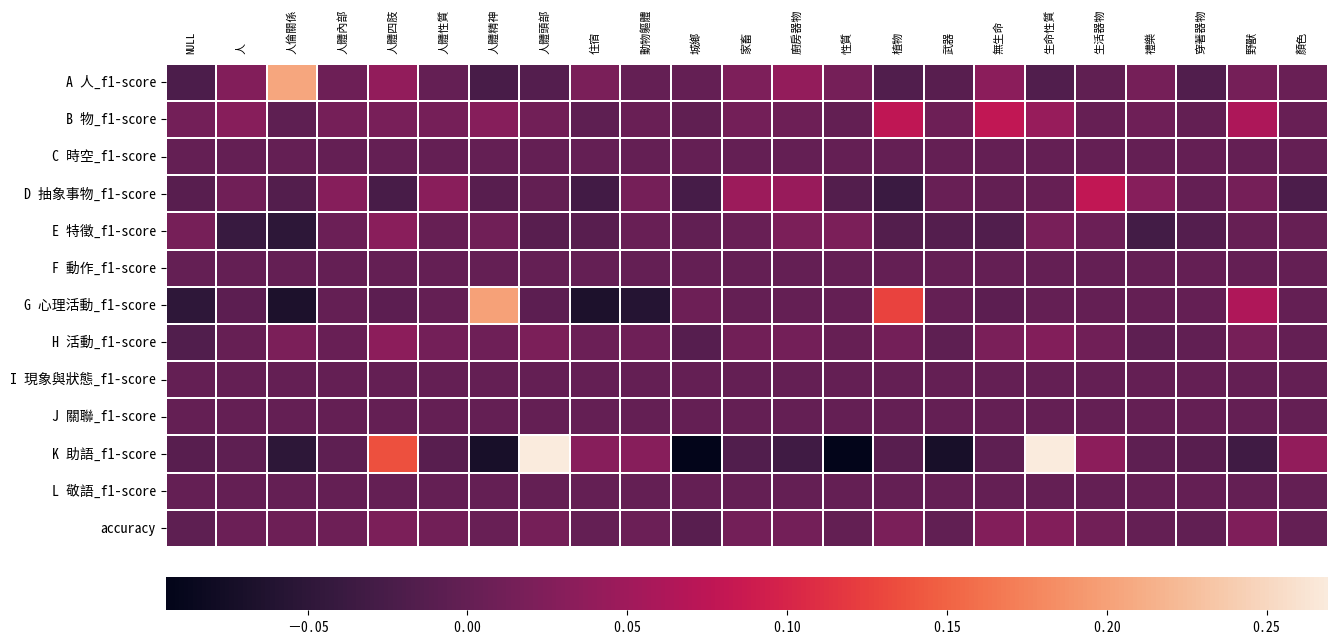

In [152]:
plt.figure(figsize=(15, 8), dpi=100)

dfT = df.T
ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                 cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
# ax.set_yticks(range(dfT.shape[0])) # <--- set the ticks first
# ax.set_yticklabels(dfT.index, fontsize=10)
# ax.set_xticks(range(dfT.shape[1])) # <--- set the ticks first
# ax.set_xticklabels(dfT.columns)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                bottom=False, top = False, labeltop=True)
plt.xticks(rotation=90, fontsize=8)
plt.show()

## Two-Character Words

ToDo: filter features with a frequency threshold

In [185]:
def heatmap(mat):
    dfT = pd.DataFrame(mat, index=rows)
    # sns.heatmap(dfT.T)
    ax = sns.heatmap(dfT.T, xticklabels=True, #linewidths=0.00, linecolor='white', 
                     # cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05)
                    )
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                    bottom=False, top = False, labeltop=True)
    # plt.xticks(rotation=90, fontsize=8)
    # plt.show()

### EDA

In [173]:
Tagger = RadicalSemanticTagger(all_words=all_words(), bigram=True, word_type="double")
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)
rows = [C.get_tag(x) for x in DTM.documents]
columns = DTM.features
print(DTM.count_mat.shape)
DTM.count_mat

(12, 523)


array([[40, 48, 39, ...,  1,  1,  0],
       [73, 16, 26, ..., 18, 35,  8],
       [51, 27,  5, ...,  1,  0,  1],
       ...,
       [23, 12,  9, ...,  0,  0,  0],
       [52, 20,  3, ...,  0,  0,  0],
       [ 4,  3,  0, ...,  0,  0,  0]])

#### $P(Lexical Group|Radical Type)$

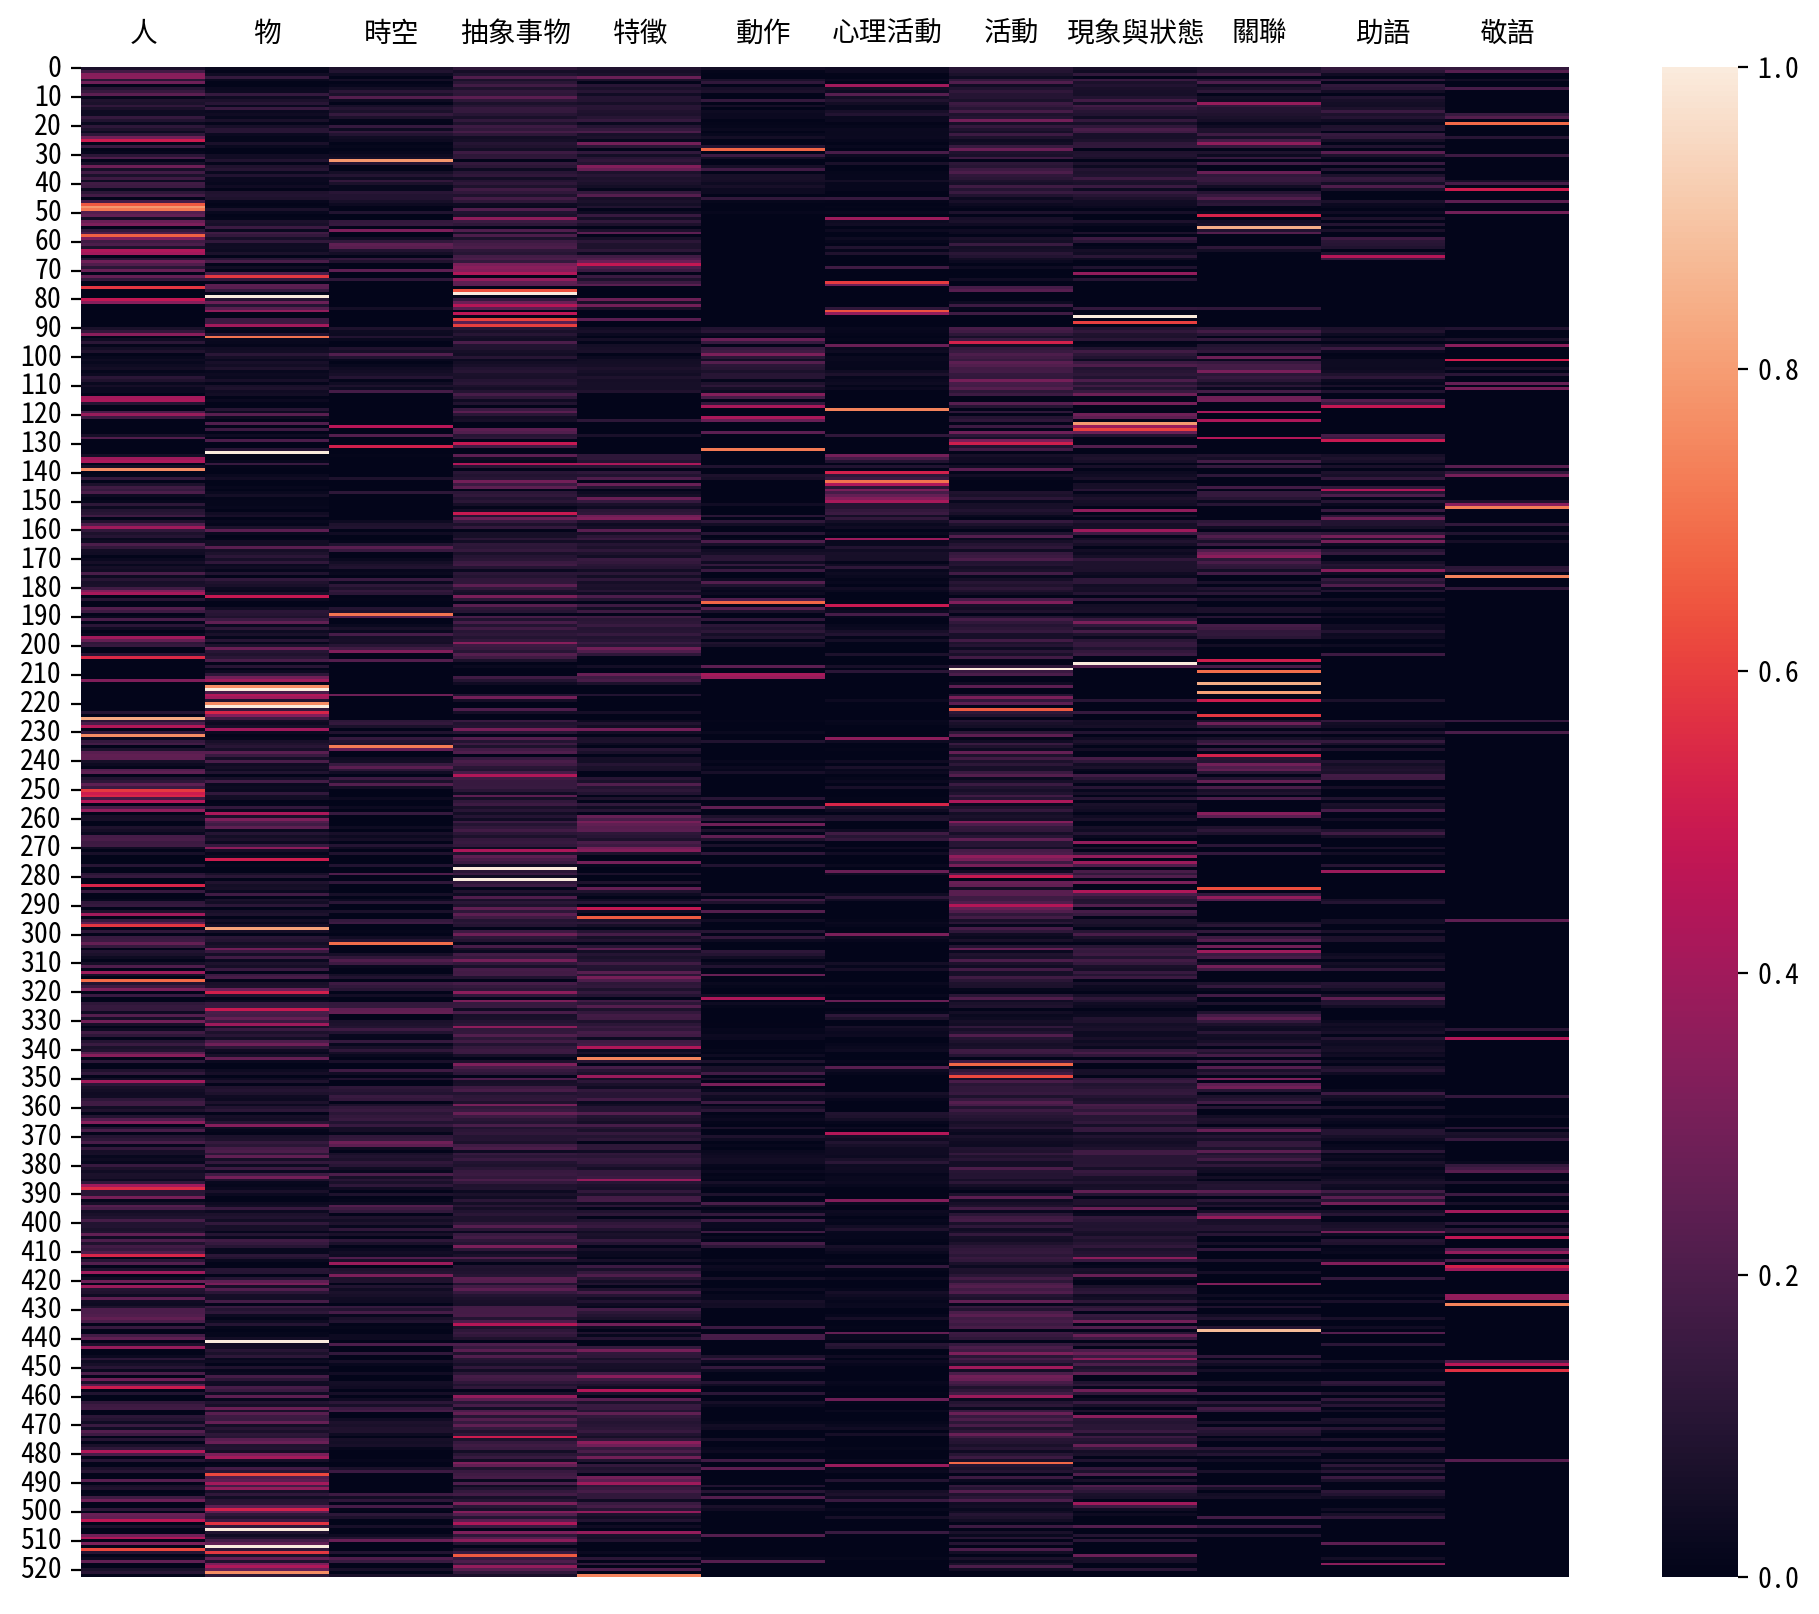

In [186]:
# np.sum(DTM.np, axis=0).shape
plt.figure(figsize=(12, 10), dpi=200)
P_givenFeat = DTM.np / np.sum(DTM.np, axis=0)
heatmap(P_givenFeat)
# sns.heatmap(P_givenFeat)

#### $P(Radical Type|Lexical Group)$

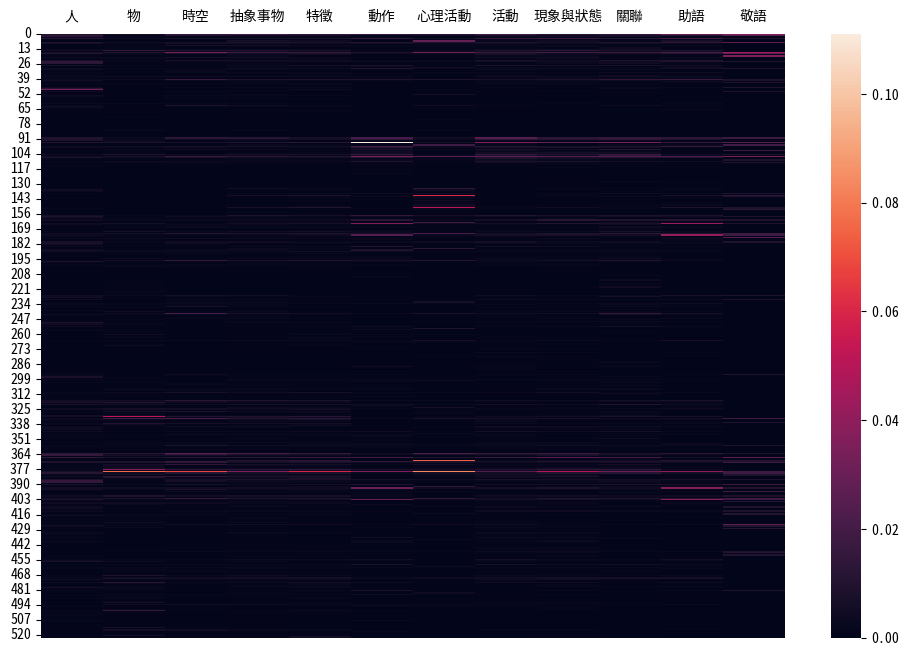

In [187]:
plt.figure(figsize=(12, 8), dpi=100)
P_givenDoc = (DTM.np.T / np.sum(DTM.np, axis=1)).T
heatmap(P_givenDoc)
# sns.heatmap(P_givenDoc)

#### Tf-IDF Matrix (single-character words)

In [ ]:
plt.figure(figsize=(12, 8), dpi=100)

dfT = pd.DataFrame(DTM.np, index=[C.get_tag(x) for x in DTM.documents], columns=DTM.features)
ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                 cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
# ax.set_yticks(range(dfT.shape[0])) # <--- set the ticks first
# ax.set_yticklabels(dfT.index, fontsize=10)
# ax.set_xticks(range(dfT.shape[1])) # <--- set the ticks first
# ax.set_xticklabels(dfT.columns)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                bottom=False, top = False, labeltop=True)
plt.xticks(rotation=90, fontsize=8)
plt.show()

### Naive Bayes Classifier

In [203]:
from sklearn.naive_bayes import MultinomialNB

DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['F 動作', 'J 關聯', 'L 敬語']


,precision,recall,f1-score,support
A 人,0.681818,0.416667,0.517241,36.000000
B 物,0.519608,0.736111,0.609195,72.000000
C 時空,0.500000,0.166667,0.250000,18.000000
D 抽象事物,0.222222,0.230769,0.226415,52.000000
E 特徵,0.311111,0.259259,0.282828,54.000000
F 動作,0.000000,0.000000,0.000000,17.000000
G 心理活動,0.384615,0.384615,0.384615,13.000000
H 活動,0.375758,0.696629,0.488189,89.000000
I 現象與狀態,0.250000,0.051282,0.085106,39.000000
J 關聯,0.000000,0.000000,0.000000,13.000000


#### Permutation Importance: Selecting Important Features

In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': 'f1_weighted',
}
imps = permutation_importance(model, X_test, y_test, scoring=scoring, #'f1_micro',  #scoring, #['f1_micro', 'accuracy'],
                              n_repeats=2, n_jobs=-1, random_state=100)


importances = imps['f1']['importances_mean']
indices = np.argsort(importances)[::-1]

df_importance = []
# Print the feature ranking
# features = list(df_feat.columns)
for i in range(X_test.shape[1]):
    df_importance.append(
        ( 
          imps['accuracy']['importances_mean'][i],
          imps['f1']['importances_mean'][i],
          imps['precision']['importances_mean'][i],
          imps['recall']['importances_mean'][i],
        )
    )
df_importance = pd.DataFrame(df_importance, index=df_feat.columns, 
                             columns=['accuracy', 'f1', 'precision', 'recall'])

In [207]:
df_importance_selected = df_importance[df_importance > 0].dropna(axis=0, how='any')

In [208]:
df_importance_selected

,accuracy,f1,precision,recall
NULL_NULL,0.003506,0.002197,0.004863,0.003506
NULL_人倫關係,0.001403,0.002424,0.003484,0.001403
NULL_人體內部,0.000701,0.000563,0.003671,0.000701
NULL_人體四肢,0.002104,0.001888,0.004345,0.002104
NULL_人體頭部,0.004208,0.003944,0.006812,0.004208
...,...,...,...,...
顏色_生活器物,0.000701,0.000440,0.000327,0.000701
顏色_禮樂,0.000701,0.001029,0.000977,0.000701
顏色_穿著器物,0.001403,0.001387,0.001392,0.001403
顏色_野獸,0.000701,0.001227,0.000664,0.000701


#### Feature Importance of Each class

In [209]:
from copy import deepcopy

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

# Base model
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# print("Not predicted:", sorted(set(y_train) - set(predictions)))
scores = classification_report(y_test, predictions, pandas=False)
baseScore = deepcopy(scores)

In [210]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score

scoreDiff = {}
rmFeat = []
for col in df_importance_selected.index:
    # X_train_drop, X_test_drop = X_train.drop(columns=[col]), X_test.drop(columns=[col])
    # Shuffle
    X_train_drop, X_test_drop = X_train.copy(deep=True), X_test.copy(deep=True)
    X_train_drop[col] = X_train_drop[col].sample(frac=1, random_state=100).values
    X_test_drop[col] = X_test_drop[col].sample(frac=1, random_state=100).values
    # df1['HS_FIRST_NAME'] = df[4].sample(frac=1).values

    rmFeat.append(col)
    model = MultinomialNB(alpha=0.001)
    model.fit(X_train_drop, y_train)
    predictions = model.predict(X_test_drop)
    # print("Not predicted:", sorted(set(y_train) - set(predictions)))
    scores = classification_report(y_test, predictions, pandas=False)

    for cls, val in scores.items():
        # scoreDiff.setdefault(cls, [])
        if cls == 'accuracy':
            if 'accuracy' not in scoreDiff:
                scoreDiff['accuracy'] = []
            scoreDiff['accuracy'].append(baseScore['accuracy']- val)
        else:
            for stat, val in val.items():
                base_val = baseScore[cls][stat]
                k = f"{cls}_{stat}"
                if any(x in k for x in 'support macro weighted'.split()): continue
                if k not in scoreDiff:
                    scoreDiff[k] = []
                scoreDiff[k].append(base_val - val)

df = pd.DataFrame(scoreDiff, index=rmFeat)

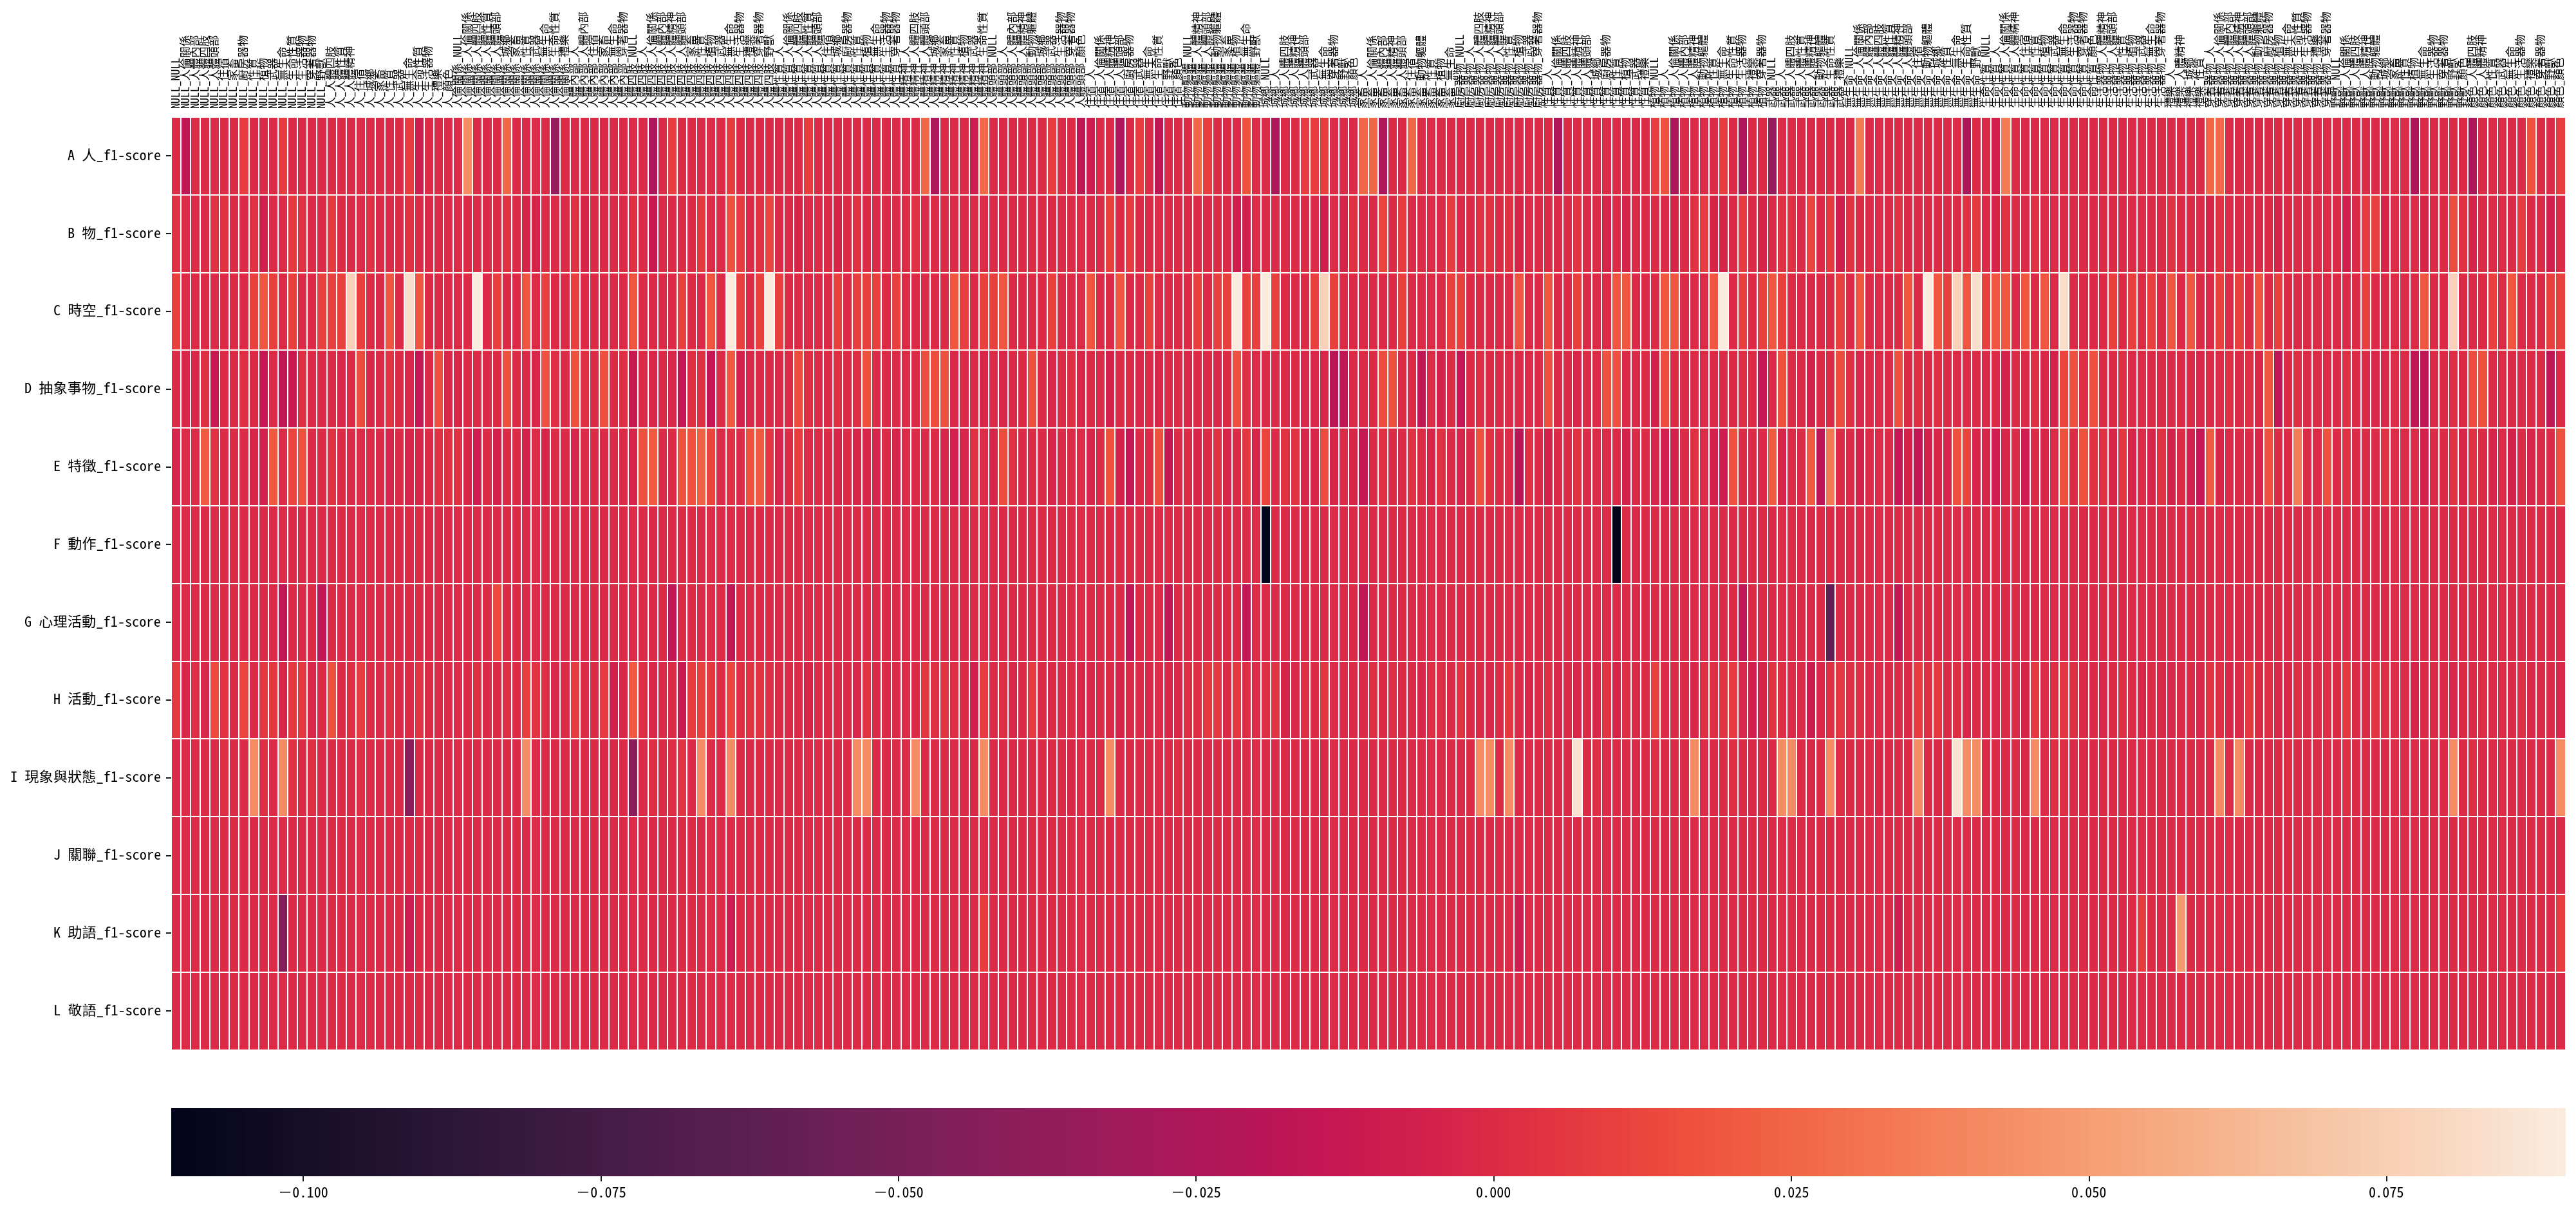

In [214]:
plt.figure(figsize=(30, 15), dpi=160)

dfT = df.filter(like='f1').T
ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                 cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
# ax.set_yticks(range(dfT.shape[0])) # <--- set the ticks first
# ax.set_yticklabels(dfT.index, fontsize=10)
# ax.set_xticks(range(dfT.shape[1])) # <--- set the ticks first
# ax.set_xticklabels(dfT.columns)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                bottom=False, top = False, labeltop=True)
plt.xticks(rotation=90, fontsize=8)
plt.show()

### Refit model with Top-165 important features

In [69]:
df_importance_selected2 = df_importance[df_importance >= 0].dropna(axis=0, how='any')
df_importance_selected2

,accuracy,f1,precision,recall
NULL,0.008178,0.008935,0.015146,0.008178
人,0.000000,0.001190,0.000365,0.000000
人倫關係,0.004673,0.003707,0.000973,0.004673
人體四肢,0.004673,0.003202,0.003739,0.004673
人體性質,0.001168,0.001967,0.002766,0.001168
...,...,...,...,...
顏色_性質,0.000000,0.000000,0.000000,0.000000
顏色_植物,0.001168,0.000698,0.000635,0.001168
顏色_生命性質,0.001168,0.000854,0.000951,0.001168
顏色_穿著器物,0.000000,0.000000,0.000000,0.000000


In [70]:
from random import sample, seed

seed(10)

acc_546feat, acc_314feat, acc_165feat, acc_rnd165feat = [], [], [], []
f1_546feat, f1_314feat, f1_165feat, f1_rnd165feat = [], [], [], []
sampled_feat = sample(DTM.features, 160)
for i in range(100):
    df_feat, df_tgt = DTM.pd, DTM.df_tgt
    X_train, X_test, y_train, y_test = train_test_split(
        df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = i
    )
    X_train_sm, X_test_sm = X_train[df_importance_selected.index], X_test[df_importance_selected.index]
    X_train_sm2, X_test_sm2 = X_train[df_importance_selected2.index], X_test[df_importance_selected2.index]
    X_train_rnd, X_test_rnd = X_train[sampled_feat], X_test[sampled_feat]

    for xtrain, xtest, acc, f1 in zip([X_train, X_train_sm, X_train_sm2, X_train_rnd], 
                                  [X_test, X_test_sm, X_test_sm2, X_test_rnd], 
                                  [acc_546feat, acc_165feat, acc_314feat, acc_rnd165feat],
                                  [f1_546feat, f1_165feat, f1_314feat, f1_rnd165feat]):
        model = MultinomialNB(alpha=0.001)
        model.fit(xtrain, y_train)
        predictions = model.predict(xtest)
        acc.append(accuracy_score(y_test, predictions))
        f1.append(f1_score(y_test, predictions, average="weighted"))

In [71]:
from statistics import stdev, median, mean

df = pd.DataFrame([
    ["546 feats",          mean(acc_546feat),    stdev(acc_546feat),    mean(f1_546feat),    stdev(f1_546feat)],
    ["314 feats",          mean(acc_314feat),    stdev(acc_314feat),    mean(f1_314feat),    stdev(f1_314feat)],
    ["165 feats",          mean(acc_165feat),    stdev(acc_165feat),    mean(f1_165feat),    stdev(f1_165feat)],
    ["165 feats (random)", mean(acc_rnd165feat), stdev(acc_rnd165feat), mean(f1_rnd165feat), stdev(f1_rnd165feat)],
], columns=['model', 'Acc.mean', 'Acc.std', 'F1.mean', 'F1.std' ])
df

,model,Acc.mean,Acc.std,F1.mean,F1.std
0,546 feats,0.440888,0.018227,0.392584,0.017578
1,314 feats,0.406612,0.015411,0.339959,0.015068
2,165 feats,0.404439,0.015093,0.331498,0.014226
3,165 feats (random),0.324346,0.014266,0.246488,0.015678


## Some Tests

In [ ]:
# Naive Bayes Posterior: P(X_i|y)
#mat = np.exp(model.feature_log_prob_).T
mat = model.feature_log_prob_.T
mat = pd.DataFrame(mat, index=DTM.features, columns=model.classes_).T
mat

,NULL,人,人倫關係,人體內部,人體四肢,人體性質,人體精神,人體頭部,住宿,動物軀體,城鄉,家畜,廚房器物,性質,植物,武器,無生命,生命性質,生活器物,禮樂,穿著器物,野獸,顏色
A 人,-2.376655,-2.235395,-2.059621,-5.195376,-2.554878,-4.968077,-4.147455,-2.779667,-3.018277,-5.886691,-3.632131,-3.702643,-5.314882,-3.422171,-3.031437,-3.785313,-2.507358,-2.287746,-3.508407,-4.270666,-3.331255,-3.723537,-5.029154
B 物,-2.825967,-3.618996,-3.290451,-4.139421,-2.668580,-5.786956,-4.844553,-3.048141,-3.152344,-4.105586,-3.325587,-3.624696,-4.062039,-3.411256,-2.000196,-3.853920,-1.664090,-3.290896,-3.587636,-4.881086,-2.789183,-2.848255,-3.762662
C 時空,-2.060038,-2.885582,-3.475231,-6.888243,-2.957646,-6.049781,-5.044695,-3.060124,-3.071231,-5.499798,-2.689217,-5.343964,-5.154269,-3.564002,-2.322321,-3.507384,-1.443196,-2.680739,-4.477548,-4.527466,-3.287676,-4.460097,-4.129516
D 抽象事物,-2.137212,-2.920629,-3.527319,-4.349630,-2.495929,-5.350698,-3.081364,-2.945896,-3.262168,-5.107369,-3.031534,-3.844411,-4.752533,-3.604164,-2.500698,-3.349826,-1.966092,-3.015748,-3.578053,-3.602216,-3.070914,-3.861297,-3.833925
E 特徵,-2.202109,-3.062194,-3.674641,-5.105987,-2.464344,-5.862133,-3.247812,-2.861097,-2.984583,-5.185950,-3.429426,-3.805003,-4.471981,-3.573579,-2.587045,-3.557557,-1.739036,-2.757485,-3.804742,-4.205354,-3.206892,-3.516845,-3.622910
F 動作,-2.547787,-2.900187,-4.992522,-7.947467,-1.257359,-4.118118,-4.816979,-2.337786,-3.006686,-4.332575,-4.519806,-3.916261,-4.431405,-3.983130,-3.258398,-2.988487,-2.388835,-2.699204,-3.786233,-4.144894,-3.748497,-3.987854,-6.250042
G 心理活動,-2.012486,-3.160328,-4.160232,-4.848871,-2.631421,-5.330984,-1.711773,-2.633997,-3.538217,-5.043825,-3.984684,-3.727024,-5.912851,-4.347825,-3.552218,-3.551174,-1.604313,-3.073344,-3.853792,-4.398411,-4.487959,-3.841791,-5.008219
H 活動,-2.228500,-2.777878,-3.917055,-5.557865,-1.872390,-4.516529,-4.037551,-2.961262,-3.299044,-4.946404,-3.586314,-3.783447,-3.820124,-3.487162,-2.859562,-3.137638,-2.063424,-2.986547,-3.140643,-3.574716,-3.251185,-3.662254,-4.466976
I 現象與狀態,-2.191941,-3.038063,-3.686735,-5.008289,-2.018702,-6.156962,-3.822508,-2.825491,-3.290864,-5.420264,-3.407158,-3.987643,-4.069795,-3.590796,-2.826944,-3.366620,-1.684610,-2.968462,-3.715589,-3.586233,-3.223765,-3.863165,-4.500293
J 關聯,-2.225884,-2.736101,-3.634023,-5.430471,-1.916247,-5.483044,-3.375546,-2.662666,-3.356664,-4.113481,-3.193194,-3.854332,-4.428500,-3.921830,-2.793016,-3.079801,-1.921470,-2.776853,-4.005211,-4.651118,-3.518181,-4.278557,-4.726978


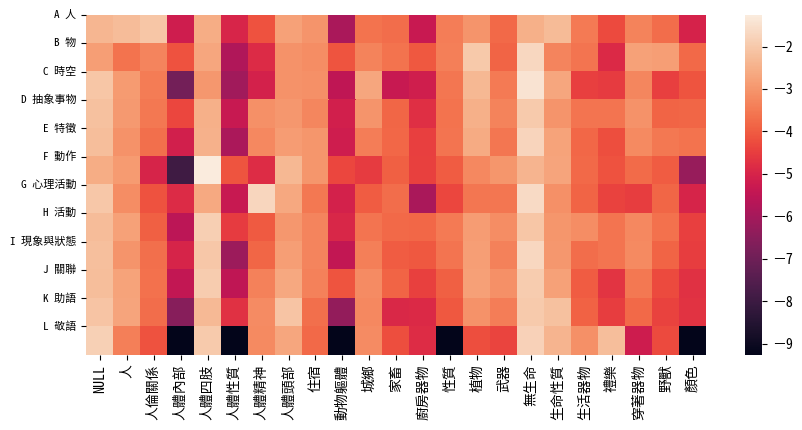

In [ ]:
plt.figure(figsize=(10, 4.5), dpi=100)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=8)
plt.show()
# ax = sns.heatmap(tf_idf_mat.toarray(), linewidth=0.5)
# plt.imshow(mat, cmap='hot', interpolation='nearest')

In [ ]:
# Tfidf matrix
DTM = DocumentTermMatrix(Tagger, C, level=1)
mat = pd.DataFrame(DTM.np.T, index=DTM.features, columns=DTM.df_tgt.lev1).T
# mat

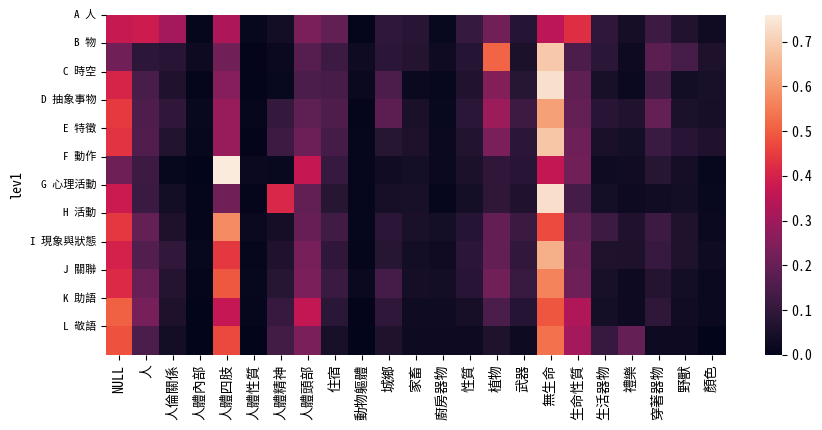

In [ ]:
plt.figure(figsize=(10, 4.5), dpi=100)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=8)
plt.show()